In [0]:
# from google.colab import drive
# import os

# drive.mount("/content/gdrive")
# path = 'gdrive/My Drive/Colab Notebooks/TransferLearning'
# os.chdir(path)
# os.listdir()

# 1. Giới thiệu chung

Trong quá trình xây dựng mô hình chắc hẳn bạn đã gặp tình huống mô hình của bạn dự báo không chuẩn xác. Mặc dù đã áp dụng những kiến trúc phức tạp và được coi là state-of-art. Bạn nghi ngờ vấn đề nằm ở dữ liệu gán nhãn sai nhưng kiểm tra cho thấy vấn đề không nằm ở gán nhãn. Bạn loay hoay với câu hỏi tại sao mô hình không chuẩn xác?

Quá trình huấn luyện một mô hình AI trên bộ dữ liệu của bạn ngay từ đầu đôi khi dẫn tới kết quả không thực sự tốt và lãng phí tài nguyên tính toán. Trong bài viết này mình sẽ giải thích những nguyên nhân chính dẫn tới việc huấn luyện mô hình không hiệu quả. Đồng thời giới thiệu một phương pháp được áp dụng phổ biến giúp cải thiện độ chính xác và tiết kiệm chi phí thời gian huấn luyện. Phương pháp được xây dựng dựa trên ý tưởng chuyển giao tri thức đã được học từ những mô hình tốt trước đó. Đó chính là transfer learning, các bạn cùng tìm hiểu qua bài viết này nhé.

## 1.1. Nguyên nhân mô hình dự báo kém

Giả sử rằng chúng ta bỏ qua những vấn đề liên quan đến sự cố dữ liệu như gán nhãn sai, ảnh mập mờ, bị che khuất, vân vân,.... Thông thường mô hình dự báo kém là do:

* **Dữ liệu nhỏ không đại diện**: Bộ dữ liệu của chúng ta có kích thước quá bé. Do đó mô hình được huấn luyện không học được các đặc trưng tổng quát để áp dụng vào các tác vụ phân loại. Ví dụ: Cùng là bài toán phân loại chó và mèo nhưng dữ liệu của bạn chỉ có 100 ảnh chó và ảnh mèo của Việt Nam. Số lượng này còn ít hơn số lượng các loài chó và mèo trên thế giới. Nếu áp dụng mô hình được huấn luyện trên bộ dữ liệu nhỏ sẽ dẫn tới khả năng dự báo sai trên những dữ liệu mới cao hơn.

* **Mô hình mất cân bằng dữ liệu**: Khi mô hình mất cân bằng dữ liệu thì việc dự đoán các mẫu thuộc nhóm thiểu số khó khăn hơn. Các kĩ thuật đã được giới thiệu ở bài [Bài 24 - Mất cân bằng dữ liệu (imbalanced dataset)](https://phamdinhkhanh.github.io/2020/02/17/ImbalancedData.html) hi vọng sẽ có ích. Trong bài này mình giới thiệu thêm kĩ thuật Data Augmentation được sử dụng cho dữ liệu ảnh.

* **Kiến trúc mô hình quá phức tạp**: Đối với những bộ dữ liệu lớn lên tới vài triệu ảnh thì mô hình có kiến trúc phức tạp có thể mang lại độ chính xác cao. Nhưng với những bộ dữ liệu kích thước nhỏ thì mô hình phức tạp lại giảm độ chính xác. Mình cho rằng nguyên nhân chính là bởi các mô hình phức tạp thường xảy ra overfitting.

* **Quá trình tối ưu hóa gặp khó khăn**: Có thể bạn đã thiết lập learning rate chưa tốt nên khiến mô hình huấn luyện lâu hội tụ hoặc chưa đạt tới điểm global optimal. Khi đó bạn có thể cân nhắc thay đổi phương pháp cập nhật gradient descent và thiết lập schedule learning rate. Trên `tensorflow.keras` chúng ta có thể thiết lập schedule learning thông qua CheckPoint như sau: 


In [0]:
import tensorflow as tf

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
your_model.fit(data, labels, epochs=100, callbacks=[callback],
          validation_data=(val_data, val_labels))

## 1.2. Vai trò của transfer learning

### 1.2.1. Chuyển giao tri thức

Trong quá trình bùng nổ của deep learning, các tài nguyên về AI ngày càng dồi dào. Song song với quá trình phát triển đó,ngày càng có nhiều các mô hình pretrain có chất lượng tốt và độ chính xác cao. Hầu như mọi domain đều có thể tìm kiếm được các mô hình pretrain.

Lý thuyết về transfer learning được Lorien Pratt thực nghiệm lần đầu năm 1993 và sau đó viết lại nó dưới dạng một lý thuyết toán học vào năm 1998 đã hiện thực hóa ý tưởng về chuyển giao tri thức giữa các mô hình như giữa con người với nhau.

Một mô hình đã có khả năng tận dụng lại các tri thức đã huấn luyện trước đó và cải thiện lại trên tác vụ phân loại của nó.

### 1.2.2. Cải thiện accuracy và tiết kiệm chi phí huấn luyện

Ví dụ trong bài toán phân loại chó và mèo. Nếu huấn luyện từ đầu, bạn sẽ tốn nhiều epochs huấn luyện hơn để đạt được độ chính xác cao. Tuy nhiên nếu bạn biết tận dụng lại các mô hình pretrained model thì sẽ cần ít epochs huấn luyện hơn để đạt được một độ chính xác mong đợi. Thậm chí độ chính xác có thể lớn hơn so với khi không áp dụng transfer learning.

![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/09/Three-ways-in-which-transfer-might-improve-learning.png)

**Hình 1:** Sơ đồ so sánh hiệu suất mô hình trước và sau khi áp dụng transfer learning. (Nguồn: Handbook Of Research On Machine Learning Applications and Trends: Algorithms, Methods and Techniques).

Từ đồ thị ta có thể thấy sử dụng transfer learning sẽ mang lại 3 lợi thế chính: 

* Có điểm khởi đầu của accuracy tốt hơn (higher start).
* Accuracy có tốc độ tăng nhanh hơn (higher slope).
* Đường tiệm cận của độ chính xác tối ưu cao hơn (higher asymptote).

### 1.2.3. Hiệu quả với dữ liệu nhỏ

Trong trường hợp bộ dữ liệu có kích thước quá nhỏ và khó có thể tìm kiếm và mở rộng thêm thì các mô hình được huấn luyện từ chúng sẽ khó có thể dự báo tốt. Tận dụng lại tri thức từ các mô hình pretrain với cùng tác vụ phân loại sẽ giúp các mô hình được huấn luyện dự báo tốt hơn với dữ liệu mới vì mô hình được học trên cả 2 nguồn tri thức đó là dữ liệu huấn luyện và dữ liệu mà nó đã được học trước đó.




# 2. Transfer Learning

## 2.1. Ví dụ về transfer learning

Quá trình áp dụng tri thức đã được học từ một mô hình trước sang bài toán hiện tại được gọi là transfer learning.

Để hiểu rõ hơn, mình lấy ví dụ:

Trong bài toán dự báo dog and cat. Chúng ta có 2 nhãn cần phân loại là dog, cat và cả 2 nhãn này đều xuất hiện trong một bộ dữ liệu imagenet. Như vậy chúng ta kì vọng rằng có thể tận dụng lại các weights từ mô hình pretrain trên bộ dữ liệu imagenet để huấn luyện lại bài toán nhanh hơn, chuẩn xác hơn.




## 2.2. Kiến trúc mô hình sử dụng transfer learning

Như chúng ta đã biết các layers CNN về bản chất là một feature extractor mà mỗi một layer CNN sẽ có tác dụng trích lọc đặc trưng theo những level khác nhau.

![](https://qph.fs.quoracdn.net/main-qimg-10cba1fabb8c6c1b39d87fa96fe862d9)

**Hình 2**: Các đặc trưng học được từ mạng CNN. Ở những Convolutional Layers đầu tiên, các bộ lọc phát hiện được các chi tiết chung dưới dạng các nét ngang, dọc và các cạnh của ảnh. Đây là những đặc trưng bậc thấp (low level feature) và khá chung chung. Chúng ta chưa thể nhận biết được vật thể dựa trên những đường nét này. Ở những Convolutional Layers cuối cùng là những đặc trưng bậc cao (high level feature) được tổng hợp từ đặc trưng bậc thấp. Đây là những đặc trưng tốt và có sức mạnh phân loại các classes.

Quá trình transfer learning sẽ tận dụng lại các đặc trưng được học từ những mô hình pretrain. Để hiểu hơn về cách thức chuyển giao, chúng ta cùng tìm hiểu về kiến trúc của mô hình sử dụng transfer learning:

* phrase 1: Là một mạng Base Network có tác dụng trích lọc đặc trưng được cấu tạo từ các Convolutional 2D Layers. Base Network sẽ được trích xuất từ một phần của mô hình pretrain sau khi loại bỏ các top fully connected layers. Để dễ hình dung mình giả định model pretrained được sử dụng là VGG16, một kiến trúc khá tốt được google phát triển vào năm 2014. Điểm cải tiến của VGG16 so với các kiến trúc CNN trước đó là sử dụng nhiều Convolutional 2D Layers nối tiếp nhau. Cụ thể các layers có cấu trúc [[Conv]_n-MaxPool]_m thay vì [Conv-MaxPool]_m, với m, n là tần suất xuất hiện của các khối mạng được lặp lại bao bọc trong ngoặc vuông.

![](https://miro.medium.com/max/470/1*3-TqqkRQ4rWLOMX-gvkYwA.png)

**Hình 3**: Kiến trúc của mạng VGG16 được sử dụng làm base network trong transfer learning.

* phrase 2: Là các Fully Connected Layers giúp giảm chiều dữ liệu và tính toán phân phối xác suất ở output. Bản chất Fully Connected Layers này chính là một mạng MLP (Multiple Layer Perceptron), một kiến trúc nguyên thủy nhất của thuật toán neural network. Số lượng các units ở output chính bằng với số lượng classes của bài toán phân loại. Các hệ số của fully connected layers sẽ được khởi tạo một cách ngẫu nhiên.

![](https://imgur.com/n01Bl58.png)

**Hình 4**: Kiến trúc base network kết hợp với fully connected layers.

Quá trình khởi tạo mô hình chúng ta sẽ tận dụng lại các weight của `base_network`. Dữ liệu ảnh sau khi đi qua `base_network` sẽ tạo ra những features tốt, những feature này chính là đầu vào input $\mathbf{X}$ cho mạng MLP để dự báo $\hat{\mathbf{y}}$. Hệ số $\mathbf{W}$ và $\mathbf{b}$ được khởi tạo ngẫu nhiên. Các hệ số của base network được load lại từ pretrain model.

Để dễ hình dung các bước và đồng thời kiểm nghiệm hiệu quả của transfer learning, chúng ta cùng thực hành trên bộ dữ liệu dog and cat.

# 3. Thực hành

## 3.1. Dataset

Để minh họa cho phương pháp transfer learning mình sẽ huấn luyện bài toán dog and cat trên bộ dữ liệu [Sub Dog and Cat](https://github.com/ardamavi/Dog-Cat-Classifier.git) với khoảng 1400 ảnh.



In [0]:
from google.colab import drive
import os

drive.mount("/content/gdrive")
path = 'gdrive/My Drive/Colab Notebooks/TransferLearning'
os.chdir(path)
os.listdir()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


['Dog-Cat-Classifier',
 'model_face_recognition.h5',
 'FacenetDataset',
 'TransferLearning_v2.ipynb',
 'TransferLearning.ipynb']

In [0]:
# !git clone https://github.com/ardamavi/Dog-Cat-Classifier.git
%cd Dog-Cat-Classifier

/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Dog-Cat-Classifier


Nhớ thực hiện khảo sát dữ liệu trước khi huấn luyện model.

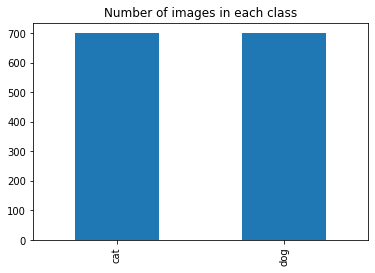

In [0]:
import pandas as pd
import glob2
import matplotlib.pyplot as plt

dogs = glob2.glob('Data/Train_Data/dog/*.jpg')
dog_labels = ['dog']*len(dogs)
cats = glob2.glob('Data/Train_Data/cat/*.jpg')
cat_labels = ['cat']*len(cats)

labels = dog_labels + cat_labels
image_links = dogs + cats

data = pd.DataFrame({'labels': labels, 'image_links':image_links})
data.groupby(labels).image_links.count().plot.bar()
plt.title('Number of images in each class')
plt.show()

Ta thấy dữ liệu giữa 2 classes là cân bằng với mỗi loại khoảng 700 ảnh. Như vậy chúng ta không xảy ra hiện tượng mất cân bằng dữ liệu. Trong trường hợp xảy ra mất cân bằng dữ liệu sẽ cần đến một số kĩ thuật xử lý đã được tổng hợp tại [Bài 24 - Mất cân bằng dữ liệu (imbalanced dataset)](https://phamdinhkhanh.github.io/2020/02/17/ImbalancedData.html).



### 3.1.1. Phân chia tập train/validation

Một thủ tục không thể thiếu của quá trình huấn luyện model đó là phân chia tập train/validation. Dữ liệu sẽ được huấn luyện trên tập dữ liệu train và kiểm định trên tập test. Một số qui trình phát triển model ngặt hơn còn phân chia thêm tập dev để fine tunning tham số giữa các mô hình và tập test để kiểm định mô hình trên tập dữ liệu thực tế mà người dùng sinh ra. Tuy nhiên để đơn giản hóa mình sẽ chỉ sử dụng tập train/validation.

Sau đó chúng ta phân chia tập train/test theo tỷ lệ 80/20. Để tỷ lệ class cân bằng giữa bộ dữ liệu train và test ta nên sử dụng hàm train_test_split của sklearn với `stratify=y`.

In [0]:
from sklearn.model_selection import train_test_split

images_train, images_val, y_label_train, y_label_val = train_test_split(image_links, labels, stratify = labels)

print('images_train len: {}, image_test shape: {}'.format(len(images_train), len(images_val)))

images_train len: 1049, image_test shape: 350


### 3.1.2. Data Augumentation

Độ chính xác của một mô hình được cải thiện hay không phần lớn dựa trên 2 yếu tố chính đó là: Kiến trúc model mà bạn áp dụng và kĩ thuật data augumentation. Đặc biệt là với các bài toán có ít dữ liệu thì áp dụng data augumentation sẽ giúp gia tăng số lượng mẫu huấn luyện và cải thiện chất lượng của model.

Để thực hiện data augumentation trên tensorflow, chúng ta có thể config ngay trên ImageDataGenerator.

Nếu bạn đọc vẫn chưa quen với khái niệm ImageDataGenerator là gì, vui lòng xem lại [Bài 32 - Kĩ thuật tensorflow Dataset](https://phamdinhkhanh.github.io/2020/04/09/TensorflowDataset.html). Đây là kiến thức cơ bản mà bất kì một modeler nào cũng đều cần nắm vững và thực hiện khi huấn luyện mô hình.

In [0]:
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical
import cv2

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self,
                 all_filenames, 
                 labels, 
                 batch_size, 
                 index2class,
                 input_dim,
                 n_channels,
                 n_classes=2, 
                 normalize=True,
                 zoom_range=[0.8, 1],
                 rotation=15,
                 brightness_range=[0.8, 1],
                 shuffle=True):
        '''
        all_filenames: list toàn bộ các filename
        labels: nhãn của toàn bộ các file
        batch_size: kích thước của 1 batch
        index2class: index của các class
        input_dim: (width, height) đầu vào của ảnh
        n_channels: số lượng channels của ảnh
        n_classes: số lượng các class 
        normalize: có chuẩn hóa ảnh hay không?
        zoom_range: khoảng scale zoom là một khoảng nằm trong [0, 1].
        rotation: độ xoay ảnh.
        brightness_range: Khoảng biến thiên cường độ sáng
        shuffle: có shuffle dữ liệu sau mỗi epoch hay không?
        '''
        self.all_filenames = all_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.index2class = index2class
        self.input_dim = input_dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.normalize = normalize
        self.zoom_range = zoom_range
        self.rotation = rotation
        self.brightness_range = brightness_range
        self.on_epoch_end()

    def __len__(self):
        '''
        return:
          Trả về số lượng batch/1 epoch
        '''
        return int(np.floor(len(self.all_filenames) / self.batch_size))

    def __getitem__(self, index):
        '''
        params:
          index: index của batch
        return:
          X, y cho batch thứ index
        '''
        # Lấy ra indexes của batch thứ index
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # List all_filenames trong một batch
        all_filenames_temp = [self.all_filenames[k] for k in indexes]

        # Khởi tạo data
        X, y = self.__data_generation(all_filenames_temp)

        return X, y

    def on_epoch_end(self):
        '''
        Shuffle dữ liệu khi epochs end hoặc start.
        '''
        self.indexes = np.arange(len(self.all_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, all_filenames_temp):
        '''
        params:
          all_filenames_temp: list các filenames trong 1 batch
        return:
          Trả về giá trị cho một batch.
        '''
        X = np.empty((self.batch_size, *self.input_dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Khởi tạo dữ liệu
        for i, fn in enumerate(all_filenames_temp):
            # Đọc file từ folder name
            img = cv2.imread(fn)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.input_dim)
            img_reshape = img.reshape(-1, 3)
            
            if self.normalize:
              mean = np.mean(img_reshape, axis=0)
              std = np.std(img_reshape, axis=0)
              img = (img-mean)/std

            if self.zoom_range:
              zoom_scale = 1/np.random.uniform(self.zoom_range[0], self.zoom_range[1])
              (h, w, c) = img.shape
              img = cv2.resize(img, (int(h*zoom_scale), int(w*zoom_scale)), interpolation = cv2.INTER_LINEAR)
              (h_rz, w_rz, c) = img.shape
              start_w = np.random.randint(0, w_rz-w) if (w_rz-w) > 0 else 0
              start_h = np.random.randint(0, h_rz-h) if (h_rz-h) > 0 else 0
              # print(start_w, start_h)
              img = img[start_h:(start_h+h), start_w:(start_w+w), :].copy()
            
            if self.rotation:
              (h, w, c) = img.shape
              angle = np.random.uniform(-self.rotation, self.rotation)
              RotMat = cv2.getRotationMatrix2D(center = (w, h), angle=angle, scale=1)
              img = cv2.warpAffine(img, RotMat, (w, h))

            if self.brightness_range:
              scale_bright = np.random.uniform(self.brightness_range[0], self.brightness_range[1])
              img = img*scale_bright
            
            label = 'dog' if 'dog' in fn else 'cat'
            label = self.index2class[label]
    
            X[i,] = img

            # Lưu class
            y[i] = label
        return X, y

dict_labels = {
    'dog': 0,
    'cat': 1
}

train_generator = DataGenerator(
    all_filenames = images_train,
    labels = y_label_train,
    batch_size = 32,
    index2class = dict_labels,
    input_dim = (224, 224),
    n_channels = 3,
    n_classes = 2,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = False,
    brightness_range=[0.8, 1],
    shuffle = True
)

val_generator = DataGenerator(
    all_filenames = images_val,
    labels = y_label_val,
    batch_size = 16,
    index2class = dict_labels,
    input_dim = (224, 224),
    n_channels = 3,
    n_classes = 2,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = False,
    brightness_range =[0.8, 1],
    shuffle = False
)

Ở đây mình đã tự viết lại các phép biến đổi ảnh sử dụng numpy và opencv. Tùy vào mục đích biến đổi ảnh mà bạn đọc có thể thêm hoặc bớt chúng. Nhưng trước tiên chúng ta phải hiểu các tham số này có ý nghĩa gì và chúng tác động tới ảnh gốc như thế nào? Mình sẽ lý giải các tham số chính:

normalize: Có thuẩn hóa mỗi một ảnh với theo phân phối chuẩn bằng cách trừ đi trung bình và chia cho phương sai toàn bộ các pixels tương ứng ở mỗi kênh.

zoom_range: Là một khoảng giá trị phóng đại ảnh: [lower, upper]. Giá trị phóng đại của một ảnh sẽ được sinh ngẫu nhiên nằm trong khoảng zoom_range. Giá trị phóng đại này càng nhỏ thì ảnh sẽ càng được phóng to.

rotation: Góc xoay ngẫu nhiên của một bức ảnh. Thông thường chỉ thiết lập từ 10-20 độ.

brightness_range: Khoảng điều chỉnh độ sáng cho bức ảnh. Độ sáng sẽ là một giá trị ngẫu nhiên từ [minVal, maxVal].

Lưu ý: Khi khởi tạo Data Generator với các mô hình sử dụng pretrained model thì chúng ta sẽ phải thực hiện các bước biến đổi dữ liệu trong data pipeline đồng nhất với pipeline được áp dụng trên pretrained model. Khi đó các features được tạo thành từ base network mới có tác dụng phân loại tốt.

Các phép biến đổi trên tập train và validation mình đã tham chiếu với biến đổi mà tác giả sử dụng khi thực hiện model pretrain với bộ dữ liệu imagenet từ trước.

### 3.1.3. Kiểm tra dữ liệu Augumentation

Chúng ta không nên tin hoàn toàn vào Augumentation mà cần khảo sát lại xem những step biến đổi trên pipeline đã thay đổi dữ liệu như thế nào? Những biến đổi đó có tạo ra các mẫu phù hợp với thực tế không? Đây là một qui trình cần thiết khi huấn luyện mô hình. 

Để kiểm tra pipeline của ImageGenerator chúng ta có thể khởi tạo vòng lặp loop qua Generator:

In [0]:
check_aug=['Data/Train_Data/cat/cat.100.jpg']*32

check_generator = DataGenerator(
    all_filenames = check_aug,
    labels = y_label_val,
    batch_size = 20,
    index2class = dict_labels,
    input_dim = (224, 224),
    n_channels = 3,
    n_classes = 2,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = 15,
    brightness_range = [0.5, 1.5],
    shuffle = False
)

In [0]:
X_batch, y_batch = check_generator.__getitem__(0)

print(X_batch.shape)
print(y_batch.shape)

(20, 224, 224, 3)
(20,)


In [0]:
# X_batch[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

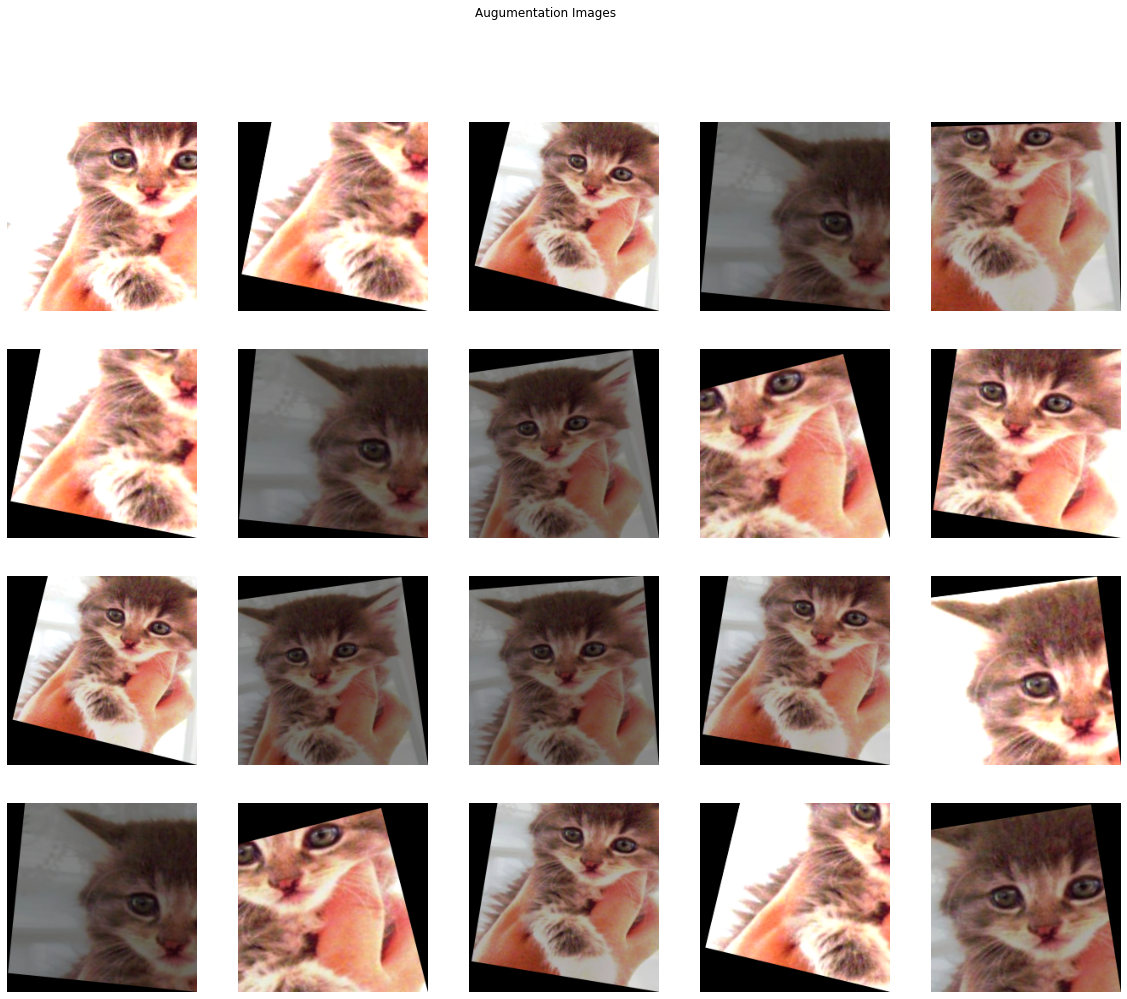

In [0]:
import matplotlib.pyplot as plt

# Khởi tạo subplot với 4 dòng 5 cột.
fg, ax = plt.subplots(4, 5, figsize=(20, 16))
fg.suptitle('Augumentation Images')

for i in np.arange(4):
  for j in np.arange(5):
    ax[i, j].imshow(X_batch[i + j + j*i]/255.0)
    ax[i, j].set_xlabel('Image '+str(i+j+j*i))
    ax[i, j].axis('off')
plt.show()

Ta có thể thấy với cùng một bức ảnh nhưng đã sinh ra khá nhiều biến thể. Các thay đổi tập trung chủ yếu ở 3 khía cạnh:

* Góc xoay của ảnh.
* Cường độ sáng của ảnh.
* Mức độ phóng đại của ảnh.

# 4. Huấn luyện model


## 4.1. Khởi tạo model huấn luyện

Tiếp theo chúng ta sẽ huấn luyện mô hình. Việc đầu tiên cần thực hiện là khởi tạo base network cho mô hình. Trên keras đã có hầu hết các model pretrain phổ biến trên bộ dữ liệu imagenet. Lý do tác giả lựa chọn bộ dữ liệu này để huấn luyện các model pretrain là vì có tới 1000 classes khác nhau. Do đó hầu như mọi bài toán classification đều có nhãn xuất hiện trong imagenet và có thể tái sử dụng pretrain model.

Ta khởi tạo model như sau:

In [0]:
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam


base_network = MobileNet(input_shape=(224, 224, 3), include_top = False, weights = 'imagenet')
flat = Flatten()
den = Dense(1, activation='sigmoid')

model = Sequential([base_network, 
                    flat,
                    den])
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_6 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 50177     
Total params: 3,279,041
Trainable params: 3,257,153
Non-trainable params: 21,888
_________________________________________________________________


Để ý kĩ bạn sẽ thấy `base network` là một pretrain model `VGG16` đã được truncate top layer thông qua tham số `include_top=False`. Bài toán của chúng ta có số lượng nhãn khác với imagenet nên sẽ ta gán vào base network một mạng MLP gồm các Layers Fully Connected sao cho layer cuối có số units = số lượng output classes.

Tiếp theo ta sẽ thực hiện quá trình warm up để huấn luyện mô hình nhanh hơn.


## 4.2. Warm up

`Warm up` là quá trình cần thiết để mô hình hội tụ nhanh hơn. Warm up sẽ đóng băng lại các layers CNN để cho hệ số của chúng không đổi và train lại trên các layers fully conntected cuối cùng. Mục đích của warm up là giữ nguyên được các đặc trưng tổng quát đã được học từ pretrained-model mà những đặc trưng này là tốt vì được huấn luyện trên bộ dữ liệu có kích thước lớn hơn và có độ chính xác cao hơn sao với khởi tạo hệ số ngẫu nhiên. Như vậy phrase 2 (xem hình 2) của mô hình sẽ không thay đổi input $\mathbf{X}$ và coi như chúng ta huấn luyện lại mạng MLP.

In [0]:
# Frozen base_network
for layer in model.layers[:1]:
  layer.trainable = False

for layer in model.layers:
  print('Layer: {} ; Trainable: {}'.format(layer, layer.trainable))

Layer: <tensorflow.python.keras.engine.training.Model object at 0x7f3130e83668> ; Trainable: False
Layer: <tensorflow.python.keras.layers.core.Flatten object at 0x7f31333581d0> ; Trainable: True
Layer: <tensorflow.python.keras.layers.core.Dense object at 0x7f3130eb1898> ; Trainable: True


Huấn luyện lại model trên 1 epoch

In [0]:
import tensorflow as tf

model.fit(train_generator,
          steps_per_epochs=len(train_generator),
          validation_data=val_generator,
          validation_steps=5,
          epochs=1)

32/32 [==============================] - 203s 6s/step - loss: 1.1109 - accuracy: 0.8613 - val_loss: 5.8674 - val_accuracy: 0.6125


Bạn sẽ thấy accuracy sẽ được cải thiện rất nhanh chỉ sau epoch đầu tiên.

Tuy nhiên bài toán có hiện tượng overfitting khi val_accuracy thấp hơn nhiều so với train_accuracy.

Để giảm thiểu overfitting chúng ta sẽ thực hiện một số hiệu chỉnh đối với mô hình như:

* Mạng nơ ron có khả năng xấp xỉ được hầu hết các hàm số. Khi kiến trúc mạng càng phức tạp và bộ dữ liệu huấn luyện có kích thước nhỏ thì khả năng học được chính xác trên từng điểm dữ liệu sẽ rất tốt. Nhưng việc học này sẽ không tốt trên dữ liệu mới. Chúng ta có thể sử dụng Dropout Layer để giảm thiểu độ phức tạp trong kiến trúc của mô hình. Dropout sẽ làm nhiệm vụ cắt tỉa bớt một số kết nối Fully Connected.

* Để giảm thiểu mức độ phức tạp của hàm số chúng ta cũng có thể sử dụng các phương pháp hiệu chuẩn (regularization) bằng cách thêm vào loss function thành phần norm chuẩn của ma trận hệ số các layers.

$$\mathcal{L}_{reg}(\mathbf{W};\mathbf{X}) = \mathcal{L}(\mathbf{W}; \mathbf{X}) + \lambda ||\mathbf{W}||_{F}^{2}$$

Trên tensorflow chúng ta có thể thêm thành phần hiệu chuẩn bằng cách khai báo trực tiếp vào tham số `kernel_regularizer` của keras layers:







In [0]:
from tensorflow.keras import regularizers
your_model.add(Dense(64, input_dim=64,
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01)))



* Một trong những nguyên nhân chủ yếu của overfitting đó là dữ liệu huấn luyện có kích thước quá bé và không tổng quát các trường hợp của ảnh. Trên thực tế bộ dữ liệu [dog and cat gốc](https://www.kaggle.com/c/dogs-vs-cats/data) có kích thước là 25000 ảnh và lớn gấp hàng chục lần dữ liệu huấn luyện với khoảng 1000 ảnh ảnh. Tăng cường thêm dữ liệu huấn luyện cho tập train là một giải pháp có thể cân nhắc tới.

* Fine tunning lại những layers của base network để cải thiện đặc trưng (sẽ được trình bày ở phần sau).

# 5. Fine tunning model

Mục đích chính của việc warm up model là để mô hình hội tụ nhanh hơn tới global optimal value.

Sau khi mô hình đạt ngưỡng tối ưu, sẽ rất khó để chúng ta tăng được thêm độ chính xác hơn nữa. 

Lúc này chúng ta sẽ cần unfrozen các layers của base network và huấn luyện mô hình trên toàn bộ các layers đã được tải trọng số từ pretrain model. Quá trình này được gọi là fine-tunning.

In [0]:
for layer in model.layers[:1]:
  layer.trainable = True

for layer in model.layers:
  print('Layer: {} ; Trainable: {}'.format(layer, layer.trainable))

Layer: <tensorflow.python.keras.engine.training.Model object at 0x7f3130e83668> ; Trainable: True
Layer: <tensorflow.python.keras.layers.core.Flatten object at 0x7f31333581d0> ; Trainable: True
Layer: <tensorflow.python.keras.layers.core.Dense object at 0x7f3130eb1898> ; Trainable: True


In [0]:
model.fit(train_generator,
          validation_data = val_generator,
          batch_size = 32,
          epochs = 5)

Epoch 1/5
32/32 [==============================] - 209s 7s/step - loss: 0.9050 - accuracy: 0.8750 - val_loss: 1.7399 - val_accuracy: 0.8542
Epoch 2/5
32/32 [==============================] - 210s 7s/step - loss: 0.7482 - accuracy: 0.8896 - val_loss: 3.9496 - val_accuracy: 0.7143
Epoch 3/5
32/32 [==============================] - 213s 7s/step - loss: 0.4872 - accuracy: 0.9121 - val_loss: 2.7001 - val_accuracy: 0.8036
Epoch 4/5
32/32 [==============================] - 210s 7s/step - loss: 0.5013 - accuracy: 0.9072 - val_loss: 0.7364 - val_accuracy: 0.9196
Epoch 5/5
32/32 [==============================] - 209s 7s/step - loss: 0.4418 - accuracy: 0.9180 - val_loss: 2.4136 - val_accuracy: 0.7946


Chúng ta có thể nhận thấy rằng sau khi thực hiện fine tunning thì đồng thời accuracy trên tập train và tập validation đều tăng và đạt tới ngưỡng >= 80%.

Như vậy fine tunning đã giải quyết được đồng thời 2 vấn đề overfitting và cải thiện accuracy của mô hình.

Đưa thêm hình về accuracy giữa transfer learning và mô hình gốc.



# 6. Kinh nghiệm transfer learning








## 6.1. Transfer learning theo kích thước dữ liệu

Các đặc trưng học được trên ít dữ liệu sẽ có tác dụng phân loại kém hơn so với các đặc trưng được trên bộ dữ liệu kích thước lớn. Do đó: 



![](https://imgur.com/Y4IIs2I.png)

**Hình 5**: Chiến lược áp dụng transfer learning.

* Đối với dữ liệu nhỏ: Train lại toàn bộ các layers sẽ làm mất đi các đặc trưng đã được học từ model pretrained và dẫn tới mô hình dự báo sẽ không chính xác. Do đó chúng ta chỉ nên train lại các fully connected layers cuối.

* Đối với dữ liệu lớn và giống domain: Có thể train lại model trên toàn bộ layers. Nhưng để quá trình huấn luyện nhanh hơn thì chúng ta sẽ thực hiện bước khởi động (warm up) và sau đó mới fine tune lại mô hình.

* Đối với dữ liệu lớn và khác domain: Chúng ta nên huấn luyện lại model từ đầu vì mô hình pretrain không tạo ra được các đặc trưng tốt cho dữ liệu khác domain.

## 6.2. Khi nào thực hiện transfer learning

Có một số trường hợp bạn áp dụng transfer learning nhưng không thấy thực sự hiệu quả. Lý do là bởi transfer learning chỉ phù hợp với một số tình huống cụ thể như sau:

* Chỉ nên transfer learning giữa 2 mô hình có cùng domain. Mô hình pretrain A và mô hình cần huấn luyện B không có chung domain về dữ liệu thì các đặc trưng học được từ bộ feature extractor của A sẽ không thực sự hữu ích trong việc phân loại của mô hình B. Cụ thể hơn. Nếu bạn muốn xây dựng một ứng dụng âm thanh đánh thức trợ lý ảo của google bằng tiếng Việt khi nói từ :"dậy đi google". Bạn đã có sẵn mô hình pretrain A đối với tác vụ `speech to text` nhưng huấn luyện trên Tiếng Anh. Như vậy bạn không nên thực hiện transfer learning trong trường hợp này. Như trong ví dụ của mình thì mô hình pretrain của imagenet đã bao gồm 2 classes dog and cat. 

* Dữ liệu huấn luyện mô hình pretrain A phải lớn hơn so với mô hình B. Nếu chúng ta transfer hệ số từ một mô hình pretrain được huấn luyện trên dữ liệu có kích thước nhỏ thì các đặc trưng học được từ mô hình A sẽ không tổng quát để giúp ích phân loại dữ liệu mô hình B.

* Mô hình pretrain A phải là mô hình có phẩm chất tốt. Đây là một yêu cầu hiển nhiên vì mô hình tốt mới tạo ra được những đặc trưng tốt.

# 7. Tổng kết

Transfer learning là một trong những phương pháp hiệu quả trong trường hợp dữ liệu có kích thước nhỏ. Ứng dụng transfer learning có thể giúp cải thiện độ chính xác của mô hình và đồng thời giảm thiểu thời gian huấn luyện.

Để có thể áp dụng được transfer learning hiệu quả đòi hỏi chúng ta phải có kinh nghiệm. Qua bài viết này mình đã hướng dẫn tới các bạn các tiêu chuẩn lựa chọn mô hình transfer learning. Hi vọng rằng các bạn sẽ áp dụng hiệu quả vào quá trình xây dựng và huấn luyện mô hình của mình.

# 8. Tài liệu

1. [Transfer learning for deep learning - Machine learning mastery](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)

2. [How to improve performance with transfer learning - Machine learning mastery](https://machinelearningmastery.com/how-to-improve-performance-with-transfer-learning-for-deep-learning-neural-networks/)

3. [Tổng hợp transfer learning SOTA - forum machine learning cơ bản](https://forum.machinelearningcoban.com/t/tong-hop-transfer-learning/5388)

4. [A comprehensive hands on guide to transfer learning with real world applications in deep learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a) 

5. [Transfer Learning - C3W2L07 - Andrew Ng](https://www.youtube.com/watch?v=yofjFQddwHE)